In [13]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers

import time
import geojson
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [81]:
request_collector = Observers.request_dumper()

# Read GeoJSON
gdf = gpd.read_file('../geodata/municipalities_sample_bbox.geojson')

# Store geometry representations
gdf['bbox'] = gdf.bounds.apply(tuple, axis=1)
gdf['wkt'] = gdf.apply(lambda f: f.geometry.wkt, axis=1)
gdf['geojson'] = gdf.apply(lambda f: f.geometry.__geo_interface__, axis=1)

# Calculate areas in m²
area_25832 = gdf.cx[:12.0,:].to_crs('EPSG:25832').area # ETRS89 / UTM Zone 32N for Vbg and Tyrol
area_25833 = gdf.cx[12.0:, :].to_crs('EPSG:25833').area   # ETRS89 / UTM Zone 33N for rest of Austria
gdf['area'] = pd.concat([area_25832,area_25833])

In [4]:
def write_cube(feature, time_range):
    '''
    This will write a zarr file using the specified parameters.
    
    # Input
    
    tuple(*attributes) feature
    list[date_string start, date_string end] time_range
    
    
    # Example: 
    
    write_cube(
        Pandas(
            Index=0,
            id='10604',
            name='Loipersbach im Burgenland',
            bbox=(16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863),
            wkt='MULTIPOLYGON (((16.47614442528707 47.71419149821737,...)))
        ),
        ['2018-01-01', '2018-01-31']
    )
    '''
    
    bands = ['B04']
    config = CubeConfig(
        dataset_name="S2L2A",
        band_names=bands,
        geometry=feature.bbox,
        #tile_size=[1024, 12],
        crs='http://www.opengis.net/def/crs/EPSG/0/4326',
        spatial_res=0.000134,
        time_range=time_range,
        time_period='2W'
    )
    open_cube(config, observer=request_collector).to_zarr(f"{feature.Index}_{feature.name}_{'_'.join(time_range)}_{time.time()}.zarr")

In [67]:
!rm -r *.zarr
times = []

for feat in gdf.drop('geometry', axis=1).itertuples():
    tr = %timeit -n 1 -r 3 -o write_cube(feat, ['2018-01-01', '2018-01-31'])
    times.append({**vars(tr), 'mean': tr.average, 'stdev': tr.stdev})

disk_usage = !du *.zarr -s | sort -h

Received chunk (0, 0, 0) for band B04: took 533.13 ms
Received chunk (1, 0, 0) for band B04: took 700.67 ms
Received chunk (2, 0, 0) for band B04: took 457.94 ms
Received chunk (0, 0, 0) for band B04: took 281.74 ms
Received chunk (1, 0, 0) for band B04: took 467.84 ms
Received chunk (2, 0, 0) for band B04: took 290.87 ms
Received chunk (0, 0, 0) for band B04: took 339.37 ms
Received chunk (1, 0, 0) for band B04: took 452.81 ms
Received chunk (2, 0, 0) for band B04: took 308.18 ms
1.74 s ± 524 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Received chunk (1, 0, 0) for band B04: took 409.10 ms
Received chunk (0, 0, 0) for band B04: took 482.75 ms
Received chunk (2, 0, 0) for band B04: took 470.84 ms
Received chunk (1, 0, 0) for band B04: took 460.88 ms
Received chunk (0, 0, 0) for band B04: took 502.30 ms
Received chunk (2, 0, 0) for band B04: took 750.79 ms
Received chunk (1, 0, 0) for band B04: took 468.23 ms
Received chunk (2, 0, 0) for band B04: took 397.33 ms
Received chunk 

In [83]:
# Build disk usage dataframe
dudf = pd.DataFrame([du.split('\t') for du in disk_usage], columns=["KB", "filename"])
dudf['Index'] = dudf['filename'].apply(lambda fn: fn.split('_')[0])

# Make sure that orginal index is used
dudf = dudf.drop_duplicates(subset='Index')
dudf = dudf.set_index('Index')
dudf.index = dudf.index.map(int)

# Append disk usage to gdf
gdf['diskusage'] = dudf['KB']
gdf

,id,name,width,height,area,perimeter,geometry,bbox,wkt,geojson,diskusage
0,10604,Loipersbach im Burgenland,0.051320,0.045033,1.927560e+07,0.192706,"POLYGON ((16.44645 47.68084, 16.49777 47.68084...","(16.446445736463346, 47.680841561177864, 16.49...","POLYGON ((16.44644573646335 47.68084156117786,...","{'type': 'Polygon', 'coordinates': (((16.44644...",940
1,31351,Weißenkirchen in der Wachau,0.081794,0.060126,4.046734e+07,0.283841,"POLYGON ((15.41051 48.36394, 15.49230 48.36394...","(15.410508300027287, 48.363936587636054, 15.49...","POLYGON ((15.41050830002729 48.36393658763605,...","{'type': 'Polygon', 'coordinates': (((15.41050...",1876
2,60348,Sankt Stefan ob Stainz,0.177447,0.059523,8.933471e+07,0.473941,"POLYGON ((15.11886 46.90973, 15.29630 46.90973...","(15.11885537162377, 46.90972705070729, 15.2963...","POLYGON ((15.11885537162377 46.90972705070729,...","{'type': 'Polygon', 'coordinates': (((15.11885...",4444
3,80104,Bludesch,0.049414,0.034666,1.442121e+07,0.168159,"POLYGON ((9.70810 47.17603, 9.75751 47.17603, ...","(9.708095987716343, 47.17603351606003, 9.75751...","POLYGON ((9.708095987716343 47.17603351606003,...","{'type': 'Polygon', 'coordinates': (((9.708095...",728
4,80201,Alberschwende,0.093974,0.059667,4.697092e+07,0.307282,"POLYGON ((9.79860 47.43165, 9.89257 47.43165, ...","(9.79859951325426, 47.43164702893876, 9.892573...","POLYGON ((9.79859951325426 47.43164702893876, ...","{'type': 'Polygon', 'coordinates': (((9.798599...",2312


In [63]:
gdf['bbox'] = gdf.bounds.apply(tuple, axis=1)
gdf['wkt'] = gdf.apply(lambda f: f.geometry.wkt, axis=1)
for feat in gdf.drop('geometry', axis=1).itertuples():
    print(feat.Index)

0
1
2
3
4


In [272]:
pd.DataFrame(times)

,_precision,all_runs,best,compile_time,loops,mean,repeat,stdev,timings,worst
0,3,"[1.3560243339743465, 1.3398812499362975, 1.275...",1.275424,0.000069,1,1.323776,3,0.034820,"[1.3560243339743465, 1.3398812499362975, 1.275...",1.356024
1,3,"[1.917747420957312, 1.9890389190986753, 1.7627...",1.762732,0.000064,1,1.889840,3,0.094473,"[1.917747420957312, 1.9890389190986753, 1.7627...",1.989039
2,3,"[2.3751987281721085, 2.1809036191552877, 2.223...",2.180904,0.000065,1,2.260000,3,0.083327,"[2.3751987281721085, 2.1809036191552877, 2.223...",2.375199
3,3,"[2.8423422230407596, 1.8981353328563273, 1.268...",1.268450,0.000067,1,2.002976,3,0.646801,"[2.8423422230407596, 1.8981353328563273, 1.268...",2.842342
4,3,"[1.7756696259602904, 2.144400909775868, 1.6212...",1.621296,0.000066,1,1.847122,3,0.219452,"[1.7756696259602904, 2.144400909775868, 1.6212...",2.144401


In [52]:
gdf

,id,name,geometry,bbox,wkt,geojson,area
0,10604,Loipersbach im Burgenland,"MULTIPOLYGON (((16.47614 47.71419, 16.47663 47...","(16.446445736463346, 47.680841561177864, 16.49...",MULTIPOLYGON (((16.47614442528707 47.714191498...,"{'type': 'MultiPolygon', 'coordinates': [(((16...",8.535781e+06
1,31351,Weißenkirchen in der Wachau,"MULTIPOLYGON (((15.46017 48.38196, 15.45800 48...","(15.410508300027287, 48.363936587636054, 15.49...",MULTIPOLYGON (((15.46016597182544 48.381964736...,"{'type': 'MultiPolygon', 'coordinates': [(((15...",2.333141e+07
2,60348,Sankt Stefan ob Stainz,"MULTIPOLYGON (((15.24401 46.91554, 15.24397 46...","(15.11885537162377, 46.90972705070729, 15.2963...",MULTIPOLYGON (((15.24400945589979 46.915542026...,"{'type': 'MultiPolygon', 'coordinates': [(((15...",4.922356e+07
3,80104,Bludesch,"MULTIPOLYGON (((9.75464 47.18317, 9.75468 47.1...","(9.708095987716343, 47.17603351606003, 9.75751...",MULTIPOLYGON (((9.7546448278179 47.18317428875...,"{'type': 'MultiPolygon', 'coordinates': [(((9....",7.585329e+06
4,80201,Alberschwende,"MULTIPOLYGON (((9.83665 47.43685, 9.83654 47.4...","(9.79859951325426, 47.43164702893876, 9.892573...",MULTIPOLYGON (((9.836646480218613 47.436853450...,"{'type': 'MultiPolygon', 'coordinates': [(((9....",2.111687e+07


In [69]:
Y = np.asarray(gdf['diskusage']).astype(int)
X = sm.add_constant(np.asarray(gdf['area']))
model = sm.OLS(Y,X).fit()
print(np.asarray(gdf['diskusage']))
model.predict(X)

['940' '1876' '4444' '728' '2312']


array([ 923.34368828, 1978.97308555, 4413.21508505,  681.53085239,
       2302.93728872])

In [85]:
gdf['area']

0    1.927560e+07
1    4.046734e+07
2    8.933471e+07
3    1.442121e+07
4    4.697092e+07
Name: area, dtype: float64

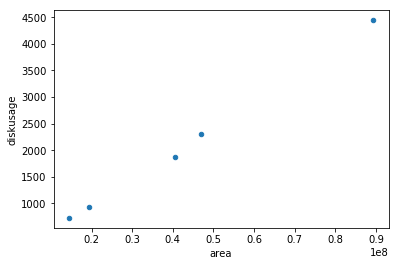

In [106]:
df = pd.concat([gdf['area'].astype(float), gdf['diskusage'].astype(float)], axis=1)
df.plot(x='area', y='diskusage', kind='scatter')